In [2]:
import os
import torch

C:\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from torchvision import datasets

In [10]:
from sklearn.preprocessing import StandardScaler

In [12]:
from sklearn.decomposition import PCA

In [14]:
import matplotlib.pyplot as plt

In [16]:
import numpy as np

In [25]:
import seaborn as sns

In [3]:
DATA_DIR = "./data"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
N_COMP = 120
SAMPLE_INDEX = 1

## Download Dataset

In [5]:
train_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=True, 
    download=True)

100%|███████████████████████████████████████████████████████████████████| 26421880/26421880 [05:51<00:00, 75126.24it/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 169480.34it/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|█████████████████████████████████████████████████████████████████████| 4422102/4422102 [01:39<00:00, 44367.91it/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|█████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 5209234.50it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



## Load Dataset

In [6]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [9]:
X, _ = load_mnist('./data/FashionMNIST/raw', kind='train')
print('Design matrix size: {}', format(X.shape))

Design matrix size: {} (60000, 784)


## Normalize Features

In [11]:
# Normalize features
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

## Perform PCA

In [13]:
# Apply PCA
pca = PCA(n_components=N_COMP)
X_norm_r = pca.fit(X_norm).transform(X_norm)

Text(0.5, 1.0, 'Component-wise and Cumulative Explained Variance')

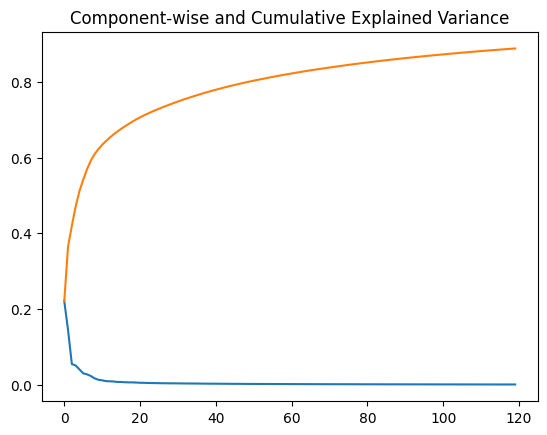

In [28]:
# Plot Component-wise and Cumulative Explained Variance:
plt.subplot(1,1,1)
plt.plot(range(N_COMP), pca.explained_variance_ratio_)
plt.plot(range(N_COMP), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component-wise and Cumulative Explained Variance")

With less than 200 components (horizontal axis) the cumulative explained variance is already greater than 95% of the total.

In [20]:
# Invert PCA to obtain the image with the new components
inversed = pca.inverse_transform(X_norm_r[SAMPLE_INDEX, :])

In [23]:
inversed = scaler.inverse_transform([inversed])

In [24]:
# Compute PCA to get the last components (in order of decreasing variance)
X_norm = X_norm.T

S = X_norm @ X_norm.T
eigvals, eigvecs = np.linalg.eig(S)
order = np.argsort(eigvals)
B = eigvecs[:, order[:N_COMP]]

C = B.T @ X_norm

X_rec = B @ C

X_rec = X_rec.T
X_rec = scaler.inverse_transform(X_rec)

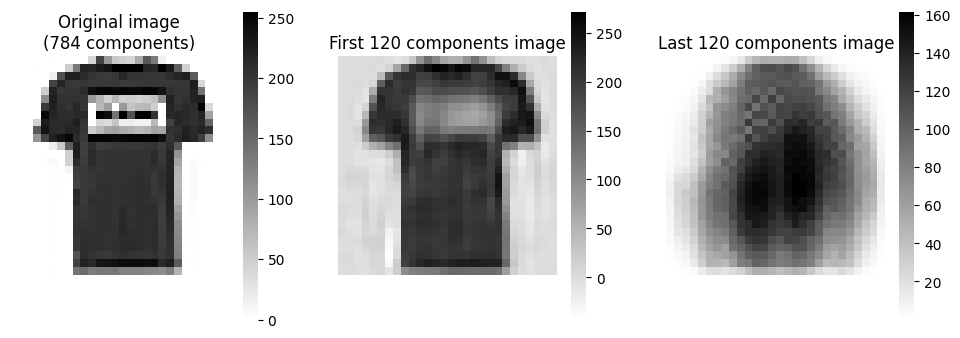

In [27]:
#Plot images:
fig, axarr = plt.subplots(1, 3, figsize=(12, 4))
sns.heatmap(X[SAMPLE_INDEX, :].reshape(28, 28), cmap='gray_r', ax=axarr[0])
sns.heatmap(inversed.reshape(28, 28), cmap='gray_r', ax=axarr[1])
sns.heatmap(X_rec[SAMPLE_INDEX, :].reshape(28, 28), cmap='gray_r', ax=axarr[2])
axarr[0].set_title("Original image\n({} components)".format(X.shape[1]), fontsize=12)
axarr[1].set_title("First {} components image".format(N_COMP), fontsize=12)
axarr[2].set_title("Last {} components image".format(N_COMP), fontsize=12)
axarr[0].set_aspect('equal')
axarr[1].set_aspect('equal')
axarr[2].set_aspect('equal')
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')

plt.show()

The image obtained using 120 components (center) looks very similar to the original image even though is represented in a subspace with a number of dimensions that is only 15.3% the number of the original dimensions. On the contrary the last 120 components carry almost no information.

References:
1. https://colab.research.google.com/drive/1N5ytOJs3HmAsVkW64A_jJT8oaBp31Yyn#scrollTo=nUOEogGnKwVm
2. https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py
3. https://medium.com/deepdreaming/understanding-your-data-principal-component-analysis-86111bc9df37